In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import os

# Cấu hình hiển thị
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
pd.set_option('display.float_format', lambda x: '%.4f' % x)

In [7]:
# Cấu hình đường dẫn
BASE_PATH = '../data/raw/'

def load_and_clean_data():
    try:
        df_reg = pd.read_csv(os.path.join(BASE_PATH, 'reg_data.csv'), sep=';')
        df_auth = pd.read_csv(os.path.join(BASE_PATH, 'auth_data.csv'), sep=';')
        df_ab = pd.read_csv(os.path.join(BASE_PATH, 'ab_test.csv'), sep=';')

        # --- FIX LỖI QUAN TRỌNG ---
        # Giữ nguyên định dạng datetime64 để tính toán cộng trừ được
        df_reg['reg_date'] = pd.to_datetime(df_reg['reg_ts'], unit='s')
        df_auth['auth_date'] = pd.to_datetime(df_auth['auth_ts'], unit='s')

        # Merge bảng Master
        df_master = df_reg.merge(df_ab, left_on='uid', right_on='user_id', how='left')
        df_master['revenue'] = df_master['revenue'].fillna(0)
        df_master['testgroup'] = df_master['testgroup'].fillna('unknown')

        print("Load dữ liệu thành công!")
        return df_reg, df_auth, df_master

    except FileNotFoundError:
        print("Không tìm thấy file. Kiểm tra lại đường dẫn!")
        return None, None, None

df_reg, df_auth, df_master = load_and_clean_data()

Load dữ liệu thành công!


--- 1. DAILY RETENTION CURVE (LOGIC KAGGLE) ---


,days_since_reg,unique_users,login_percent
0,0,1000000,100.00%
1,10,50759,5.08%
2,20,38618,3.86%
3,30,26971,2.70%
4,40,16243,1.62%
5,50,11966,1.20%
6,60,11267,1.13%
7,70,11195,1.12%
8,80,11105,1.11%
9,90,10683,1.07%


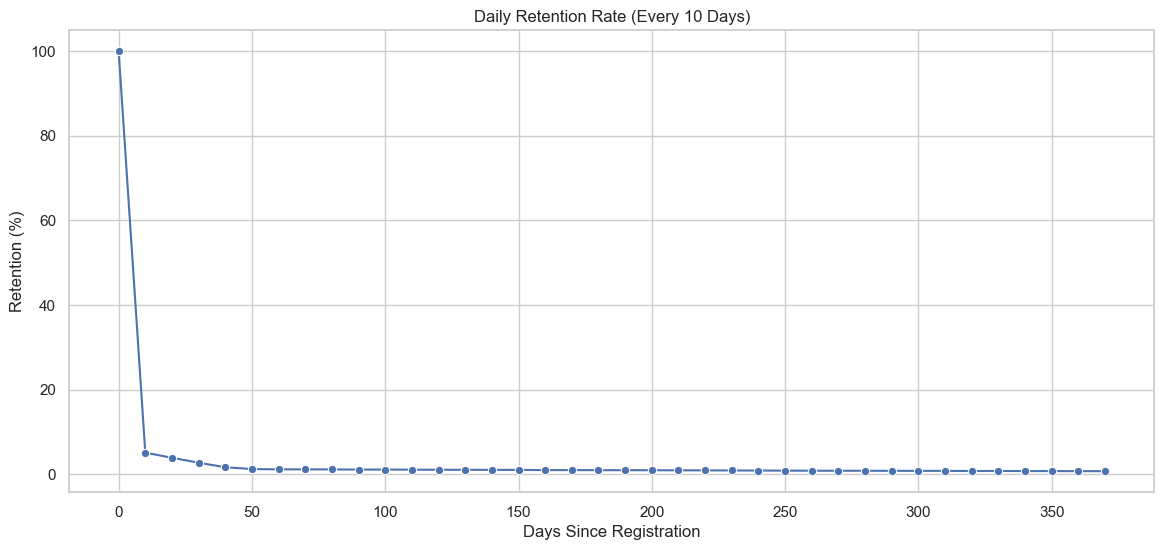

In [8]:
if df_reg is not None:
    print("--- 1. DAILY RETENTION CURVE (LOGIC KAGGLE) ---")

    # 1. Merge & Tính toán
    merged_df = pd.merge(df_reg, df_auth, on='uid', how='left')

    # Tính khoảng cách ngày (Làm tròn về ngày để trừ)
    merged_df['days_since_reg'] = (merged_df['auth_date'].dt.floor('d') - merged_df['reg_date'].dt.floor('d')).dt.days

    # 2. Đếm user duy nhất (Nunique)
    retention_counts = (
        merged_df.groupby('days_since_reg')['uid']
        .nunique()
        .reset_index(name='unique_users')
        .sort_values(by='days_since_reg')
    )

    # 3. Tính %
    total_users = df_reg['uid'].nunique()
    retention_counts['login_percent'] = (retention_counts['unique_users'] / total_users) * 100

    # 4. Lọc chu kỳ 10 ngày
    results_curve = retention_counts[retention_counts['days_since_reg'] % 10 == 0].reset_index(drop=True).head(38)

    # Hiển thị bảng
    display(results_curve.style.format({'login_percent': '{:.2f}%'}).background_gradient(cmap='Blues'))

    # Vẽ biểu đồ
    plt.figure(figsize=(14, 6))
    sns.lineplot(data=results_curve, x='days_since_reg', y='login_percent', marker='o')
    plt.title('Daily Retention Rate (Every 10 Days)')
    plt.ylabel('Retention (%)')
    plt.xlabel('Days Since Registration')
    plt.show()

--- 2. COHORT ANALYSIS (HEATMAP) ---


C:\Users\Admin\AppData\Local\Temp\ipykernel_20416\1271571863.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cohort_data['reg_day_str'] = cohort_data['reg_date'].dt.strftime('%Y-%m-%d')


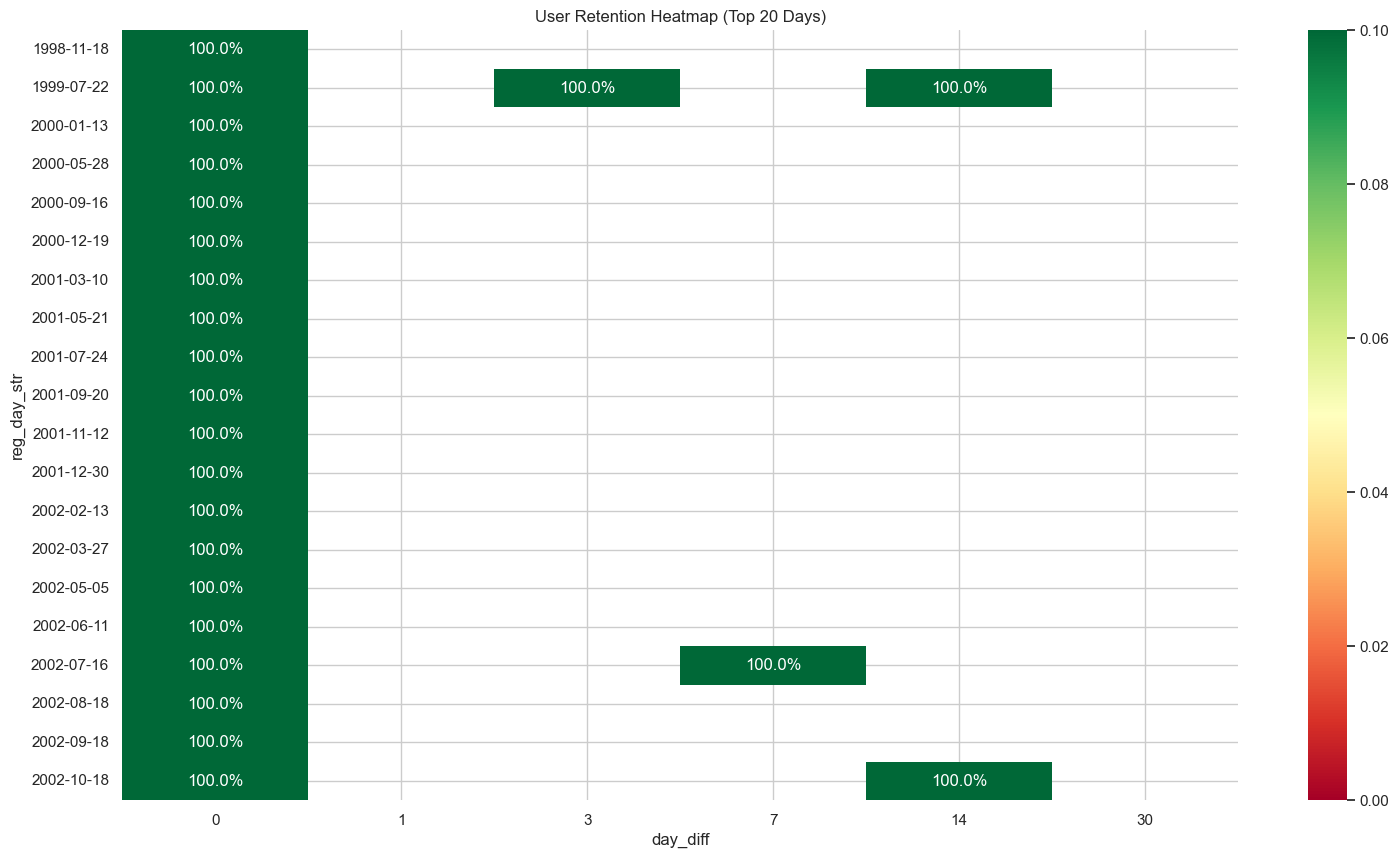

In [9]:
if df_reg is not None:
    print("--- 2. COHORT ANALYSIS (HEATMAP) ---")

    # 1. Join lại để lấy data
    df_cohort = df_auth.merge(df_reg[['uid', 'reg_date']], on='uid', how='inner')

    # 2. Tính khoảng cách ngày (Đã fix lỗi .dt)
    df_cohort['day_diff'] = (df_cohort['auth_date'].dt.floor('d') - df_cohort['reg_date'].dt.floor('d')).dt.days

    # 3. Lọc các ngày quan trọng (0, 1, 3, 7, 14, 30)
    target_days = [0, 1, 3, 7, 14, 30]
    cohort_data = df_cohort[df_cohort['day_diff'].isin(target_days)]

    # 4. Lấy 'Ngày đăng ký' (Chỉ lấy phần ngày để group)
    cohort_data['reg_day_str'] = cohort_data['reg_date'].dt.strftime('%Y-%m-%d')

    # 5. Pivot Table
    cohort_pivot = cohort_data.groupby(['reg_day_str', 'day_diff'])['uid'].nunique().reset_index()
    cohort_matrix = cohort_pivot.pivot(index='reg_day_str', columns='day_diff', values='uid')

    # 6. Tính %
    cohort_size = cohort_matrix[0]
    retention_rate = cohort_matrix.divide(cohort_size, axis=0)

    # 7. Vẽ Heatmap (Lấy 20 ngày đầu để demo cho đẹp)
    plt.figure(figsize=(18, 10))
    sns.heatmap(retention_rate.head(20), annot=True, fmt='.1%', cmap='RdYlGn', vmin=0.0, vmax=0.1)
    plt.title('User Retention Heatmap (Top 20 Days)')
    plt.show()

--- 3. A/B TESTING (BOOTSTRAP) ---
Chênh lệch thực tế (B - A): $-0.1186


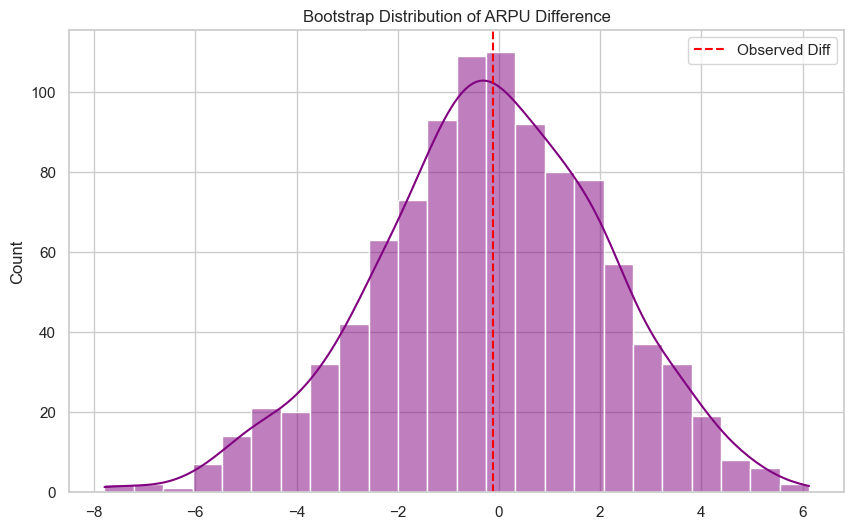

KẾT LUẬN: Không có sự khác biệt rõ ràng.


In [10]:
if df_master is not None:
    print("--- 3. A/B TESTING (BOOTSTRAP) ---")

    group_a = df_master[df_master['testgroup'] == 'a']['revenue']
    group_b = df_master[df_master['testgroup'] == 'b']['revenue']

    diff_orig = group_b.mean() - group_a.mean()
    print(f"Chênh lệch thực tế (B - A): ${diff_orig:.4f}")

    # Bootstrap Simulation
    boot_diffs = []
    for _ in range(1000):
        boot_a = group_a.sample(frac=1, replace=True).mean()
        boot_b = group_b.sample(frac=1, replace=True).mean()
        boot_diffs.append(boot_b - boot_a)

    # Vẽ biểu đồ
    plt.figure(figsize=(10, 6))
    sns.histplot(boot_diffs, kde=True, color='purple')
    plt.axvline(diff_orig, color='red', linestyle='--', label='Observed Diff')
    plt.title('Bootstrap Distribution of ARPU Difference')
    plt.legend()
    plt.show()

    # Kết luận
    p_value_proxy = (np.array(boot_diffs) <= 0).mean()
    if p_value_proxy < 0.05:
        print("KẾT LUẬN: Nhóm B tốt hơn nhóm A có ý nghĩa thống kê.")
    else:
        print("KẾT LUẬN: Không có sự khác biệt rõ ràng.")

--- 4. WHALE ANALYSIS ---
Ngưỡng Top 1%: $37323.66
Doanh thu Whales: $1,269,869.00 (13.1%)


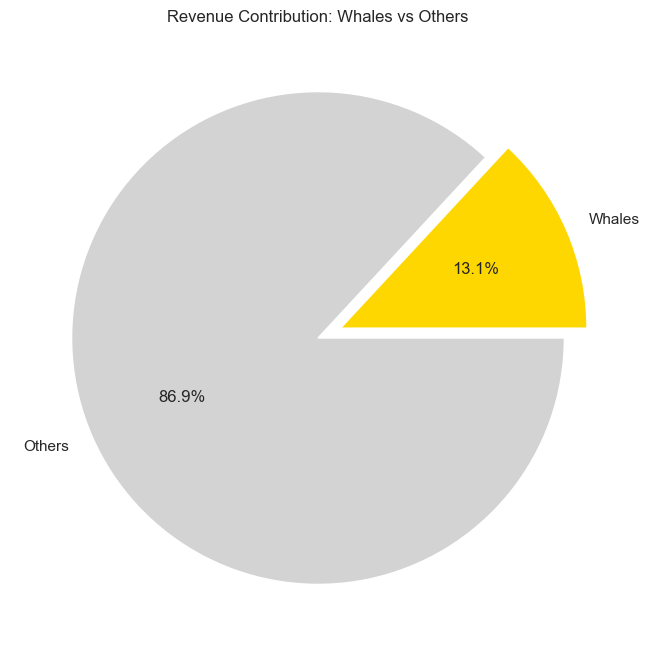

In [11]:
if df_master is not None:
    print("--- 4. WHALE ANALYSIS ---")

    paying_users = df_master[df_master['revenue'] > 0]
    top_1_val = np.percentile(paying_users['revenue'], 99)

    whales = paying_users[paying_users['revenue'] >= top_1_val]
    others = paying_users[paying_users['revenue'] < top_1_val]

    whale_rev = whales['revenue'].sum()
    total_rev = paying_users['revenue'].sum()

    print(f"Ngưỡng Top 1%: ${top_1_val:.2f}")
    print(f"Doanh thu Whales: ${whale_rev:,.2f} ({whale_rev/total_rev:.1%})")

    # Biểu đồ tròn
    plt.figure(figsize=(8, 8))
    plt.pie([whale_rev, total_rev - whale_rev], labels=['Whales', 'Others'], autopct='%1.1f%%', colors=['gold', 'lightgray'], explode=(0.1, 0))
    plt.title('Revenue Contribution: Whales vs Others')
    plt.show()